In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder

In [2]:
!pip install shap
import shap
#clear the output 
from IPython.display import clear_output
clear_output(wait=False)

In [3]:
df = pd.read_csv('./dataset/data_file.csv', sep=',')

categorical_columns = ['Machine', 'MajorImageVersion', 'MajorOSVersion', 'MajorLinkerVersion', 'MinorLinkerVersion', 'DllCharacteristics', 'NumberOfSections']
df[categorical_columns] = df[categorical_columns].astype('category')

binary_columns = ['Benign', 'BitcoinAddresses']

numeric_columns = df.select_dtypes(include=['int64']).columns.difference(binary_columns)

df.drop(columns=['FileName', 'md5Hash'], inplace=True)

df['LinkerVersion'] = df['MajorLinkerVersion'].astype(str) + '.' + df['MinorLinkerVersion'].astype(str)
df['LinkerVersion'] = df['LinkerVersion'].astype('category')
df.drop(columns=['MajorLinkerVersion', 'MinorLinkerVersion'], inplace=True)

categorical_columns = [col for col in categorical_columns if col not in ['MajorLinkerVersion', 'MinorLinkerVersion']]
categorical_columns.append('LinkerVersion')

df.drop(columns=['BitcoinAddresses'], inplace=True)

### AI models explainability

As we've seen before, for our classification we used Logistic Regression and Random Forest, which have notable differences in terms of explainability. In fact, Logistic Regression is a white box model, meaning that is easily explainable by displaying the coefficients used for the classification. On the other hand, Random Forest is a black box model,  meaning that we need post-hoc techniques such as SHAP values to be able to explain the model.

Since we've seen that categorical features offer a very good balance between performances and computational effort, we're going to explain Logistic Regression and Random Forest when using categorical variables for classification.

#### Logistic Regression Explainability using coefficients

For Logistic Regression it's possible to display the coefficients assigned to each feature to see the importance of each one of them.

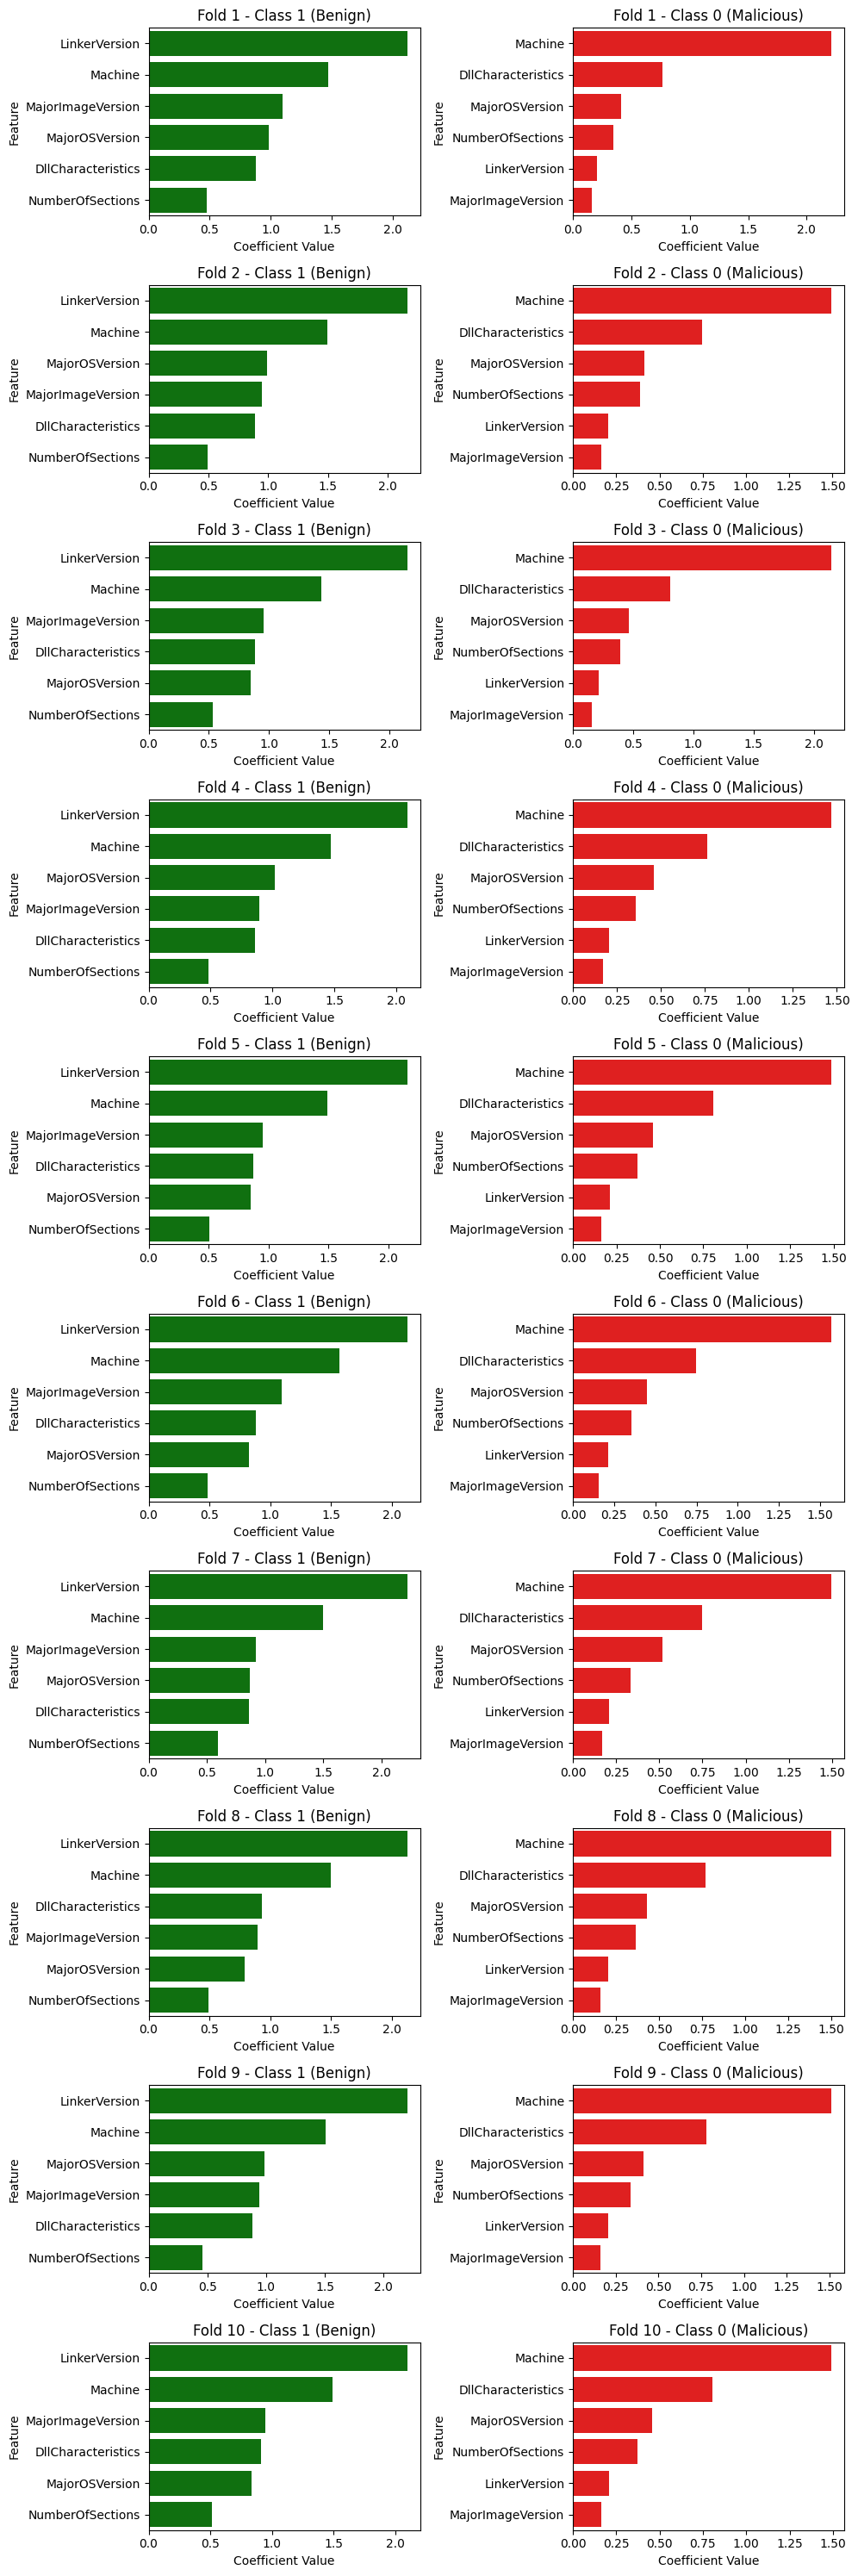

In [8]:
X = df[categorical_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat_transform', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


fig, axes = plt.subplots(nrows=10, ncols=2, figsize=(10, 30))

# iterate on folds
for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    pipeline.fit(X_train, y_train)          # train the model on the current fold
    
    y_pred = pipeline.predict(X_test)       # obtain the predictions

    # Extract model coefficients
    coefficients = pipeline.named_steps['classifier'].coef_[0]

    # Extract the one-hot encoded feature names
    ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat_transform']
    ohe_feature_names = ohe.get_feature_names_out(categorical_columns)

    # Create a mapping from one-hot encoded features to their original categorical feature
    feature_coefficients_pos = {}
    feature_coefficients_neg = {}

    for feature in categorical_columns:
        # Find all one-hot encoded features that belong to the current categorical feature
        matching_features = [f for f in ohe_feature_names if f.startswith(feature)]
    
        # Get their indices in the coefficient array
        indices = [ohe_feature_names.tolist().index(f) for f in matching_features]

        # Aggregate coefficients (e.g., by taking the mean)
        feature_coefficients_pos[feature] = np.mean([coefficients[i] for i in indices if coefficients[i] > 0])
        feature_coefficients_neg[feature] = np.mean(np.abs(([coefficients[i] for i in indices if coefficients[i] < 0])))

    # Print the coefficients for this fold
    # print(f"Fold {i + 1}:")
    # for feature, coef in feature_coefficients.items():
    #     print(f"  Feature: {feature}, Coefficient: {coef}")
    # print("\n")  # Empty line for readability

    coefpos_df_fold = pd.DataFrame.from_dict(feature_coefficients_pos, orient='index', columns=['Coefficient'])
    coefpos_df_fold = coefpos_df_fold.sort_values(by='Coefficient', ascending=False)

    ax_pos = axes[i, 0]
    sns.barplot(x=coefpos_df_fold['Coefficient'], y=coefpos_df_fold.index, ax=ax_pos, color='green')
    ax_pos.set_title(f"Fold {i + 1} - Class 1 (Benign)")
    ax_pos.set_xlabel("Coefficient Value")
    ax_pos.set_ylabel("Feature")

    coefneg_df_fold = pd.DataFrame.from_dict(feature_coefficients_neg, orient='index', columns=['Coefficient'])
    coefneg_df_fold = coefneg_df_fold.sort_values(by='Coefficient', ascending=False)

    ax_neg = axes[i, 1]
    sns.barplot(x=coefneg_df_fold['Coefficient'], y=coefneg_df_fold.index, ax=ax_neg, color='red')
    ax_neg.set_title(f"Fold {i + 1} - Class 0 (Malicious)")
    ax_neg.set_xlabel("Coefficient Value")
    ax_neg.set_ylabel("Feature")


plt.tight_layout()
plt.show()


To be able to print the coefficients for the logistic regression the model's learned coefficients are extracted and interpreted as measures of feature importance. Because one-hot encoding expands each categorical variable into several binary variables, the coefficients of these encoded features are grouped and averaged to reflect the importance of the original categorical variable.

Finally, the aggregated feature importance scores are visualized using bar plots for each fold and for each class, allowing for comparison of feature influence across different training/test splits.

#### Models Explainability using SHAP

SHAP is a popular method for interpretable machine learning, based on game theory. It assigns SHAPley values to each feature in a model, quantifying its contribution to a particular prediction. SHAP is widely used because:

It provides a consistent and fair way to distribute feature importance.
It explains both global feature importance (how features influence predictions overall) and local explanations (why a model made a specific prediction).
It works well with tree-based models, deep learning, and linear models like Logistic Regression.

##### Logistic Regression Explainability using SHAP

Since we're working with categorical features that are one-hot encoded , SHAP values are computed on these binary encoded columns, but we want to aggregate them back to the original categorical feature, for each test instance. To do that:
1. We get the features names after one hot encoding: ohe_feature_names
2. We build a mapping from encoded column to original feature: feature_map
3. We aggregate SHAP values for each row (instance): agg_shap_per_row

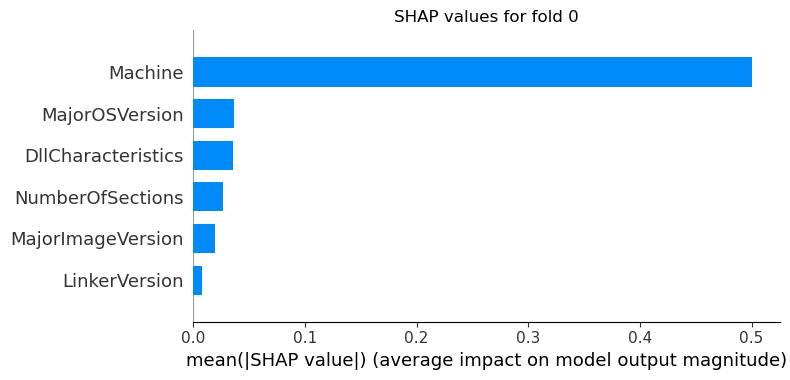

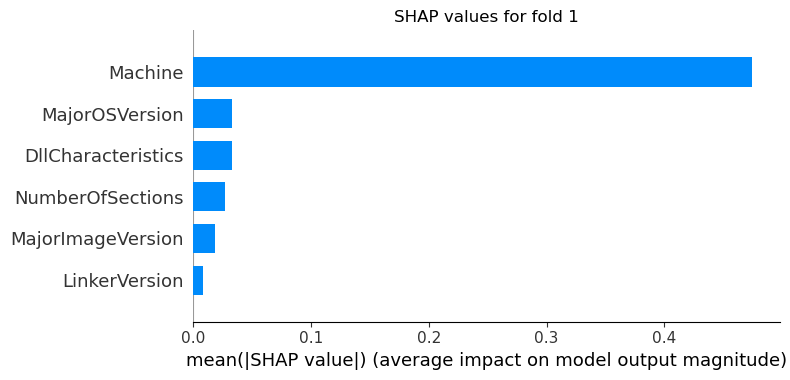

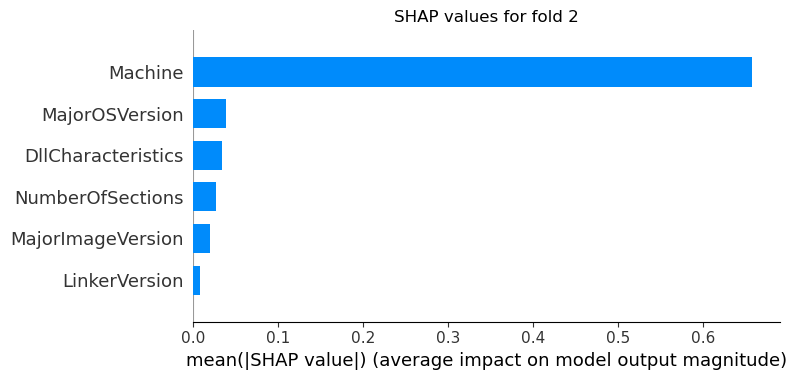

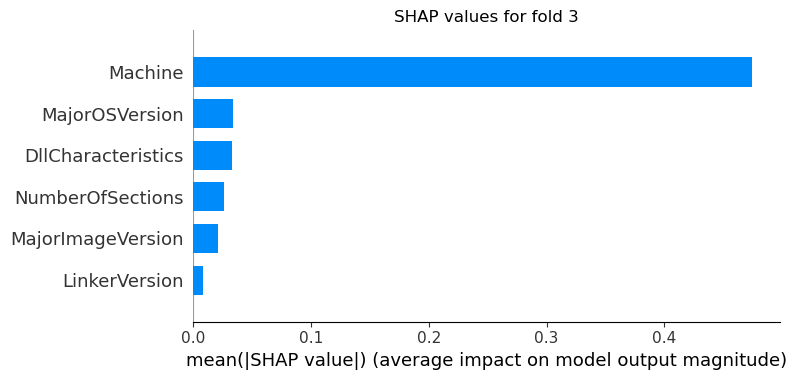

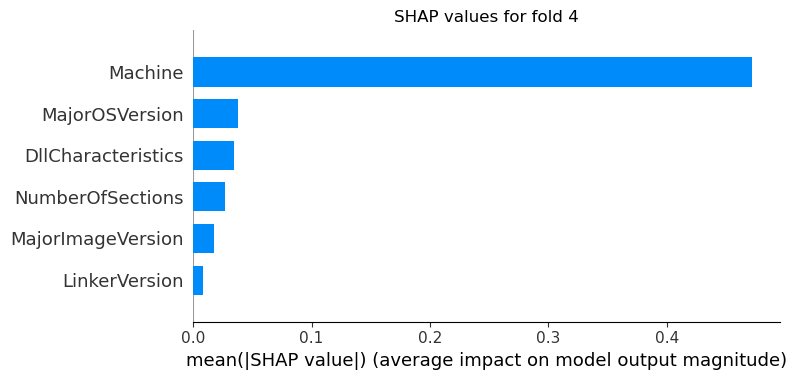

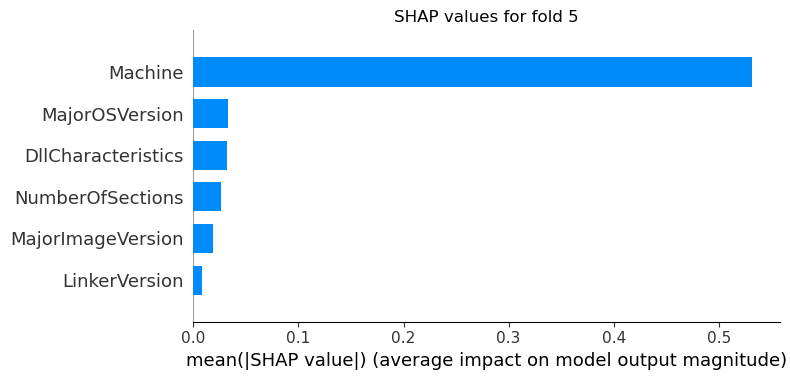

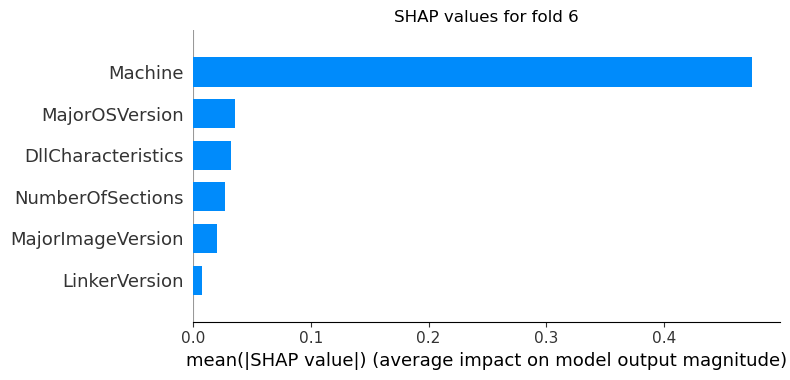

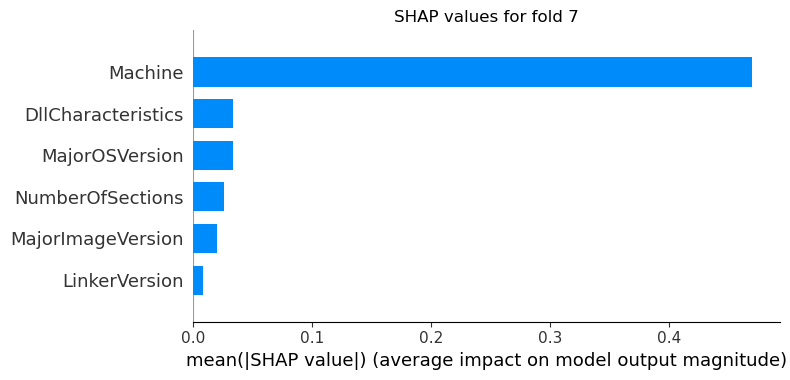

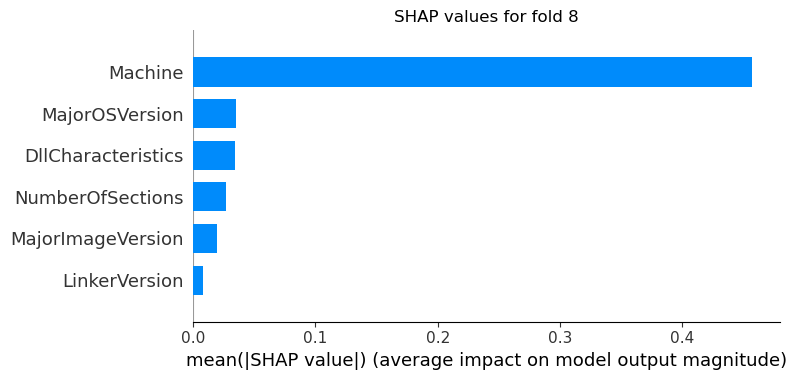

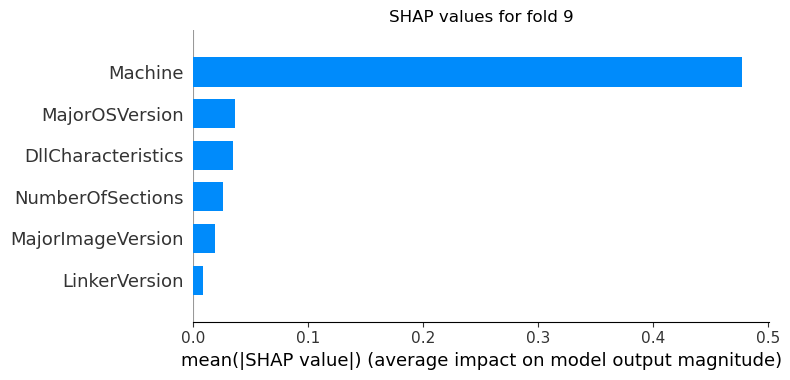

In [ ]:
X = df[categorical_columns]  
y = df["Benign"]
 
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_transform", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ]
)
 
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])
 
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
 
    pipeline.fit(X_train, y_train)
 
    # Get feature names from one-hot encoder
    ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat_transform"]
    ohe_feature_names = ohe.get_feature_names_out(categorical_columns)
 
    # Create SHAP explainer on the trained LogisticRegression
    explainer = shap.Explainer(pipeline.named_steps["classifier"],pipeline.named_steps["preprocessor"].transform(X_test))
    shap_values = explainer(pipeline.named_steps["preprocessor"].transform(X_test))

    # Depending on shap version, for binary classification you may have only 1 array.
    # In fact, here we have only one bidimensional array shap_values.
    shap_df = pd.DataFrame(shap_values.values, columns=ohe_feature_names)
    #print(shap_df)

    # Build a map from each encoded column to its original feature
    feature_map = {}
    for encoded_col in ohe_feature_names:
        # Encoded name typically "Machine_332", etc.
        orig_feature = encoded_col.split('_')[0]
        feature_map.setdefault(orig_feature, []).append(encoded_col)
    #print(feature_map)

    # Initialization of dictionary to contain aggregate values 
    agg_shap_per_row = []

    # Iterate on all rows of shap_df (all the objects in X_test)
    for index, row in shap_df.iterrows():
        # Dictionaries to contain aggregate values for the current row
        row_agg_shap = {}
        
        # Somma dei valori SHAP per ogni feature originale
        # Sum of SHAP values for each original feature, splitting considering positive and negative SHAP values
        for orig_feat, enc_feats in feature_map.items():
            # Sum SHAP values of columns that belong to the same original feature
            row_agg_shap[orig_feat] = row[enc_feats].mean()
            
        agg_shap_per_row.append(row_agg_shap)

    # Converts the list of aggregated results into a DataFrame
    agg_shap_df = pd.DataFrame(agg_shap_per_row)

    plt.title(f"SHAP values for fold {i + 1}")
    shap.summary_plot(agg_shap_df.values, features=agg_shap_df.columns, plot_type="bar")
    plt.show()


For each fold of the 10-fold cross-validation, we generate a bar summary plot of SHAP values, where:
- Each bar represents an original categorical feature (not the one-hot encoded dummies).
- The length of the bar indicates the impact of that feature on the model’s output for that fold.


Now, we plot SHAP values considering each class independently.
Since SHAP values are computed for the encoded features, we group the SHAP values of one-hot encoded features back into their original feature for both class 0 (Malicious) and class 1 (Benign).
What we do in the following code is:
1) Get Feature Names After One-Hot Encoding: ohe_feature_names
2) Create a Mapping from Encoded Columns to Original Feature: feature_map
3) Aggregate SHAP Values for Each Instance (Row): for class 0, we aggregate negative SHAP values; for class 1, we aggregate positive SHAP values.

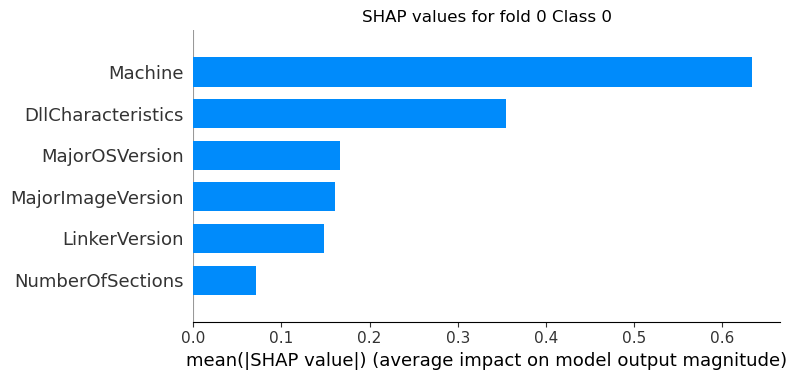

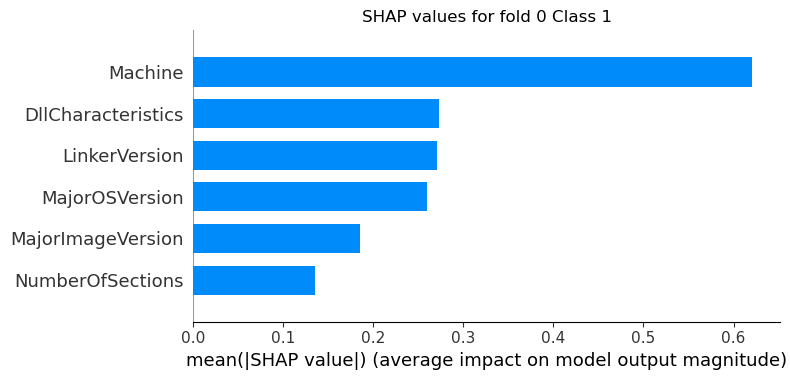

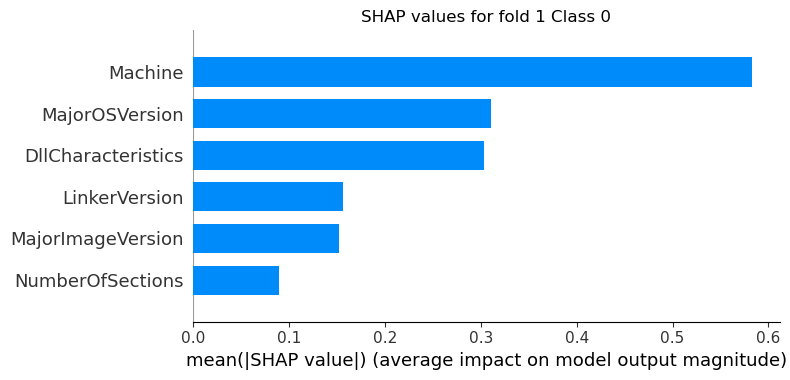

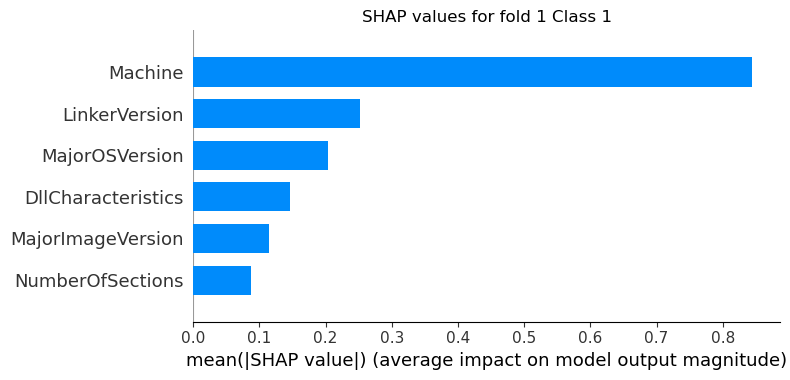

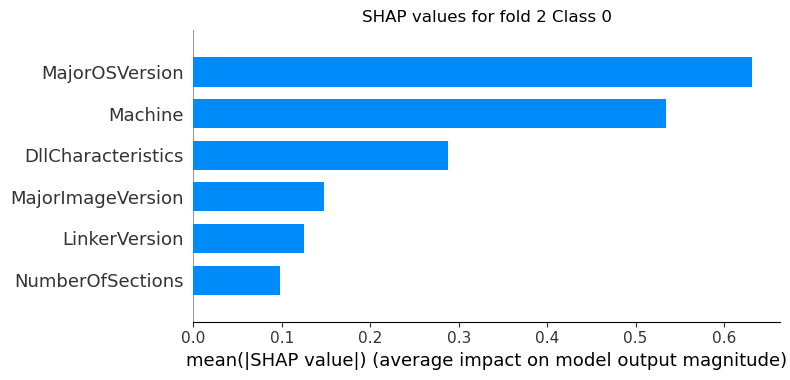

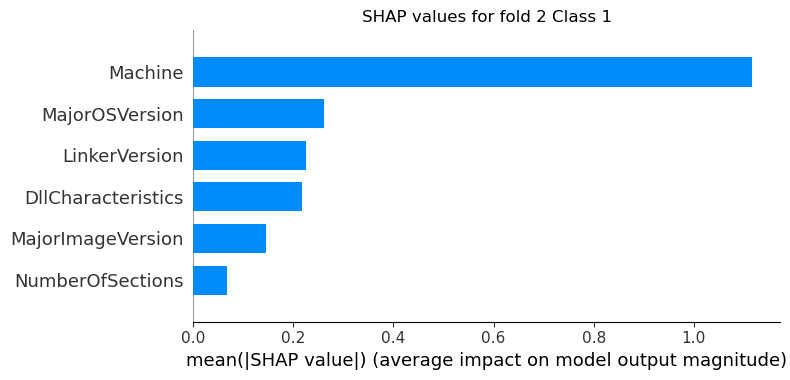

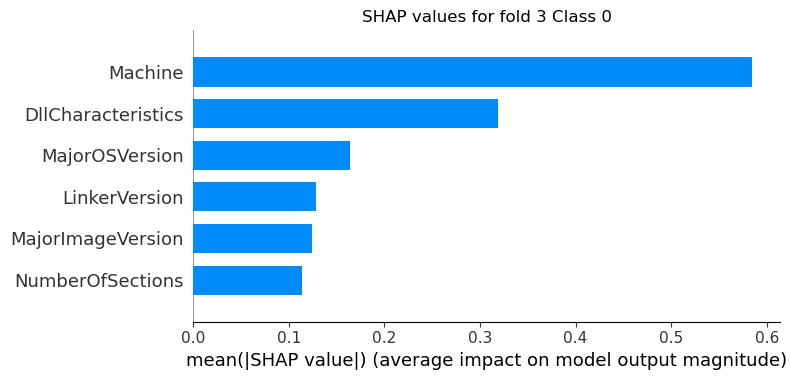

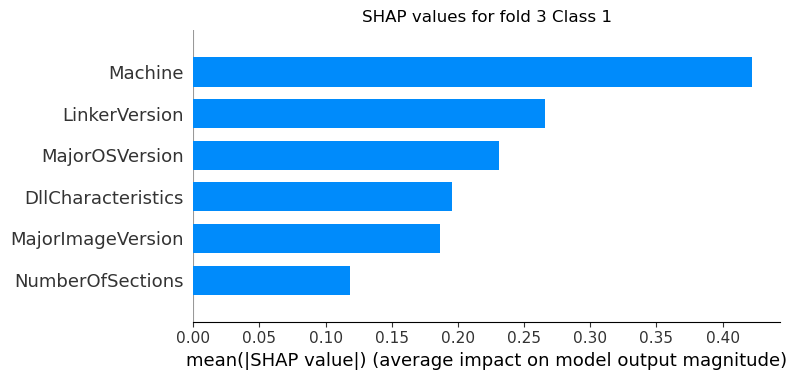

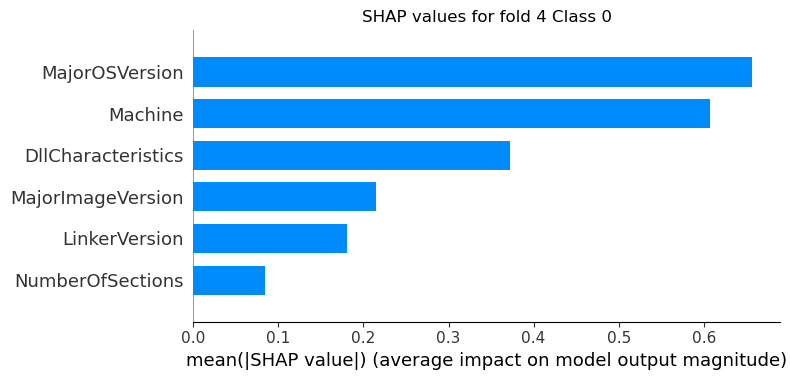

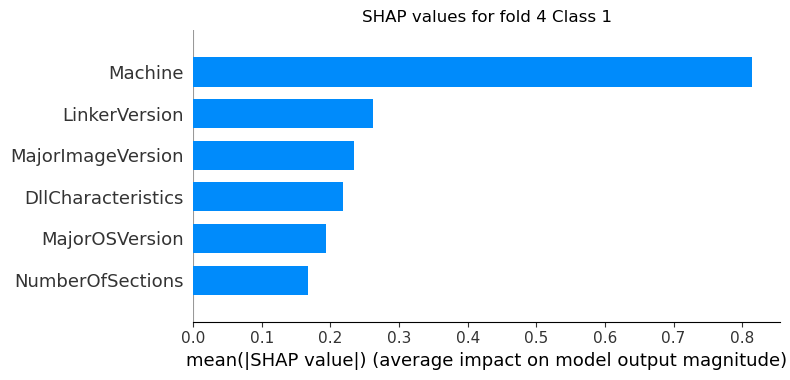

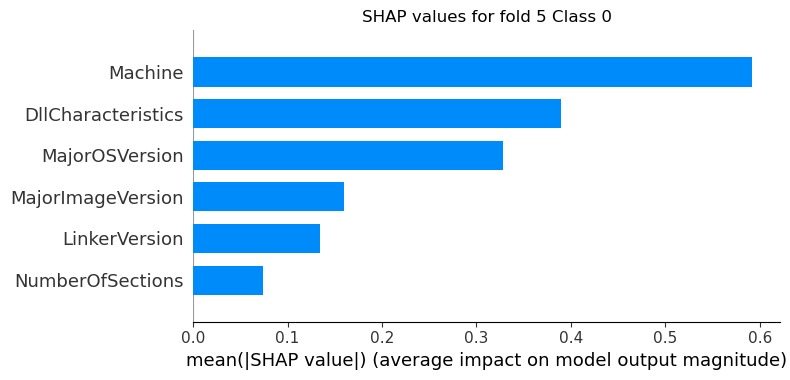

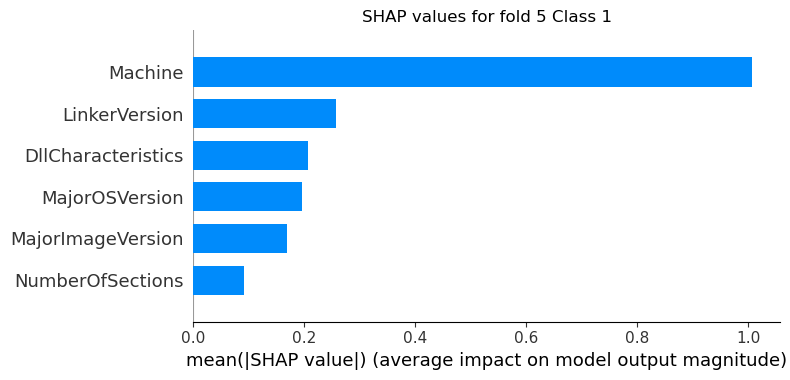

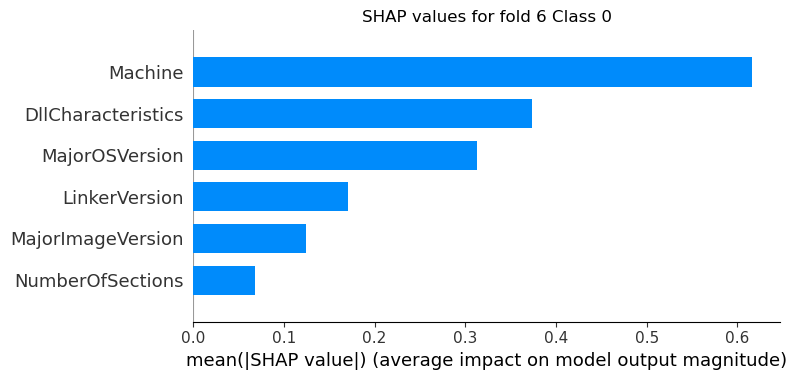

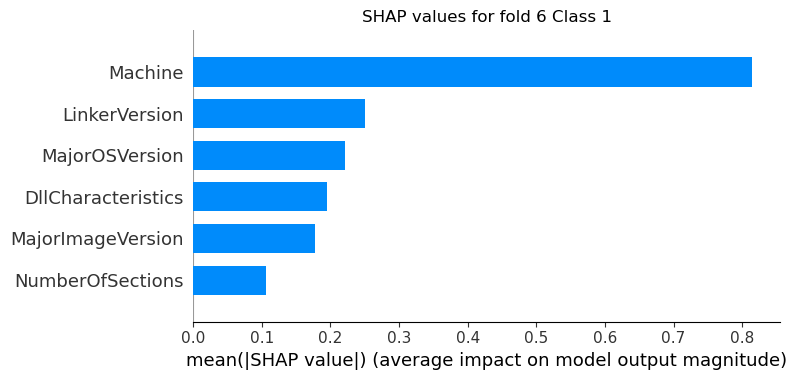

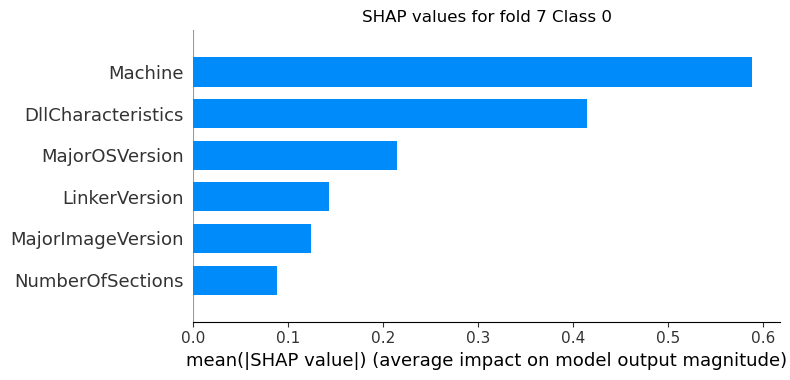

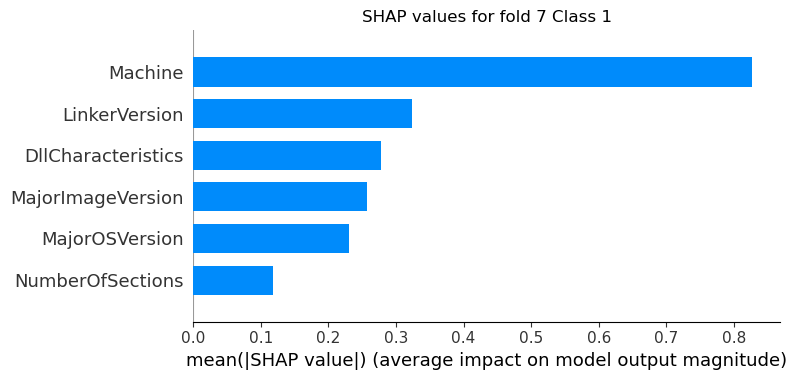

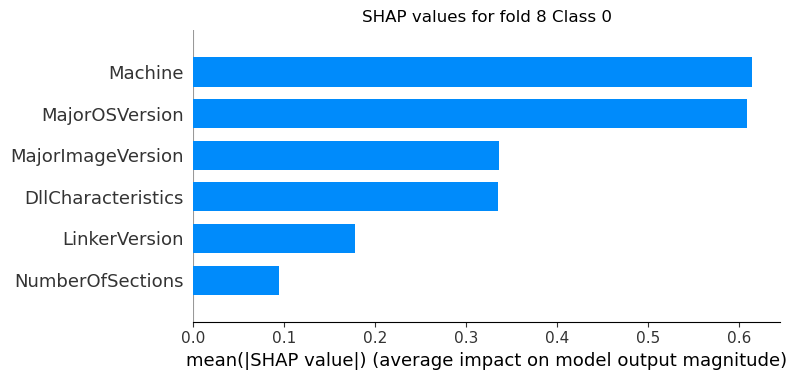

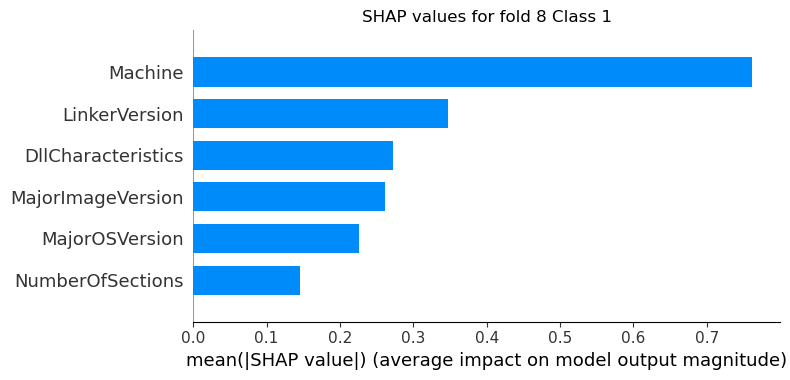

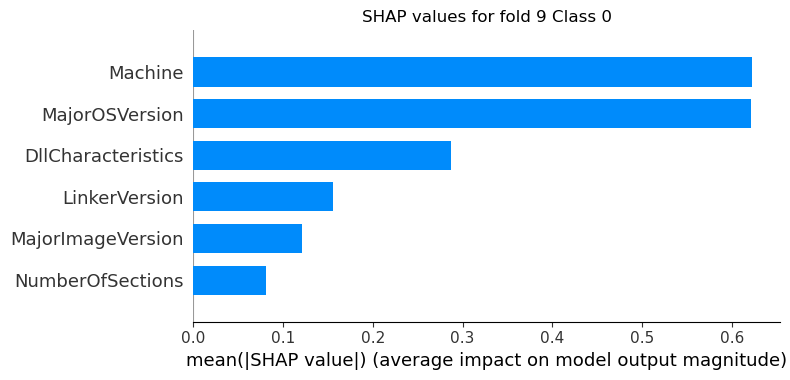

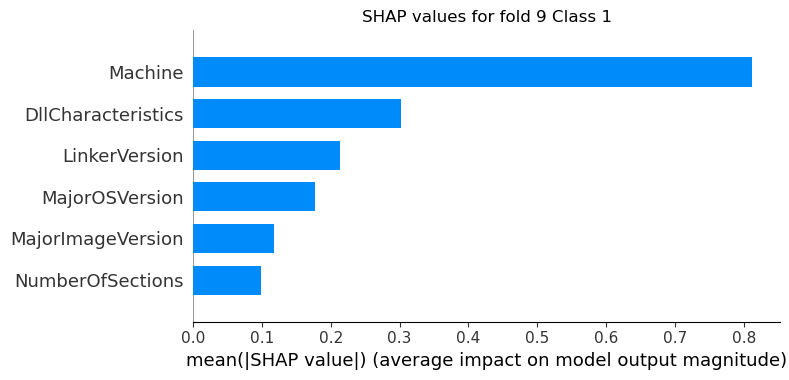

In [ ]:
X = df[categorical_columns]  
y = df["Benign"]
 
preprocessor = ColumnTransformer(
    transformers=[
        ("cat_transform", OneHotEncoder(handle_unknown="ignore"), categorical_columns)
    ]
)
 
pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])
 
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
 
    pipeline.fit(X_train, y_train)
 
    # Get feature names from one-hot encoder
    ohe = pipeline.named_steps["preprocessor"].named_transformers_["cat_transform"]
    ohe_feature_names = ohe.get_feature_names_out(categorical_columns)
 
    # Create SHAP explainer on the trained LogisticRegression
    explainer = shap.Explainer(pipeline.named_steps["classifier"],pipeline.named_steps["preprocessor"].transform(X_test))
    shap_values = explainer(pipeline.named_steps["preprocessor"].transform(X_test))
 

    # Depending on shap version, for binary classification you may have only 1 array.
    # In fact, here we have only one bidimensional array shap_values.
    shap_df = pd.DataFrame(shap_values.values, columns=ohe_feature_names)
    #print(shap_df)

    # Build a map from each encoded column to its original feature
    feature_map = {}
    for encoded_col in ohe_feature_names:
        # Encoded name typically "Machine_332", etc.
        orig_feature = encoded_col.split('_')[0]
        feature_map.setdefault(orig_feature, []).append(encoded_col)
    #print(feature_map)

    # Initialization of dictionary to contain aggregate values 
    # class 0 -> ('Malicious', value 0)
    # class 1 -> ('Benign', value 1)
    agg_shap_per_row_class0 = []
    agg_shap_per_row_class1 = []

    # Iterate on all rows of shap_df (all the objects in X_test)
    for index, row in shap_df.iterrows():
        # Dictionaries to contain aggregate values for the current row
        row_agg_shap_class0 = {}
        row_agg_shap_class1 = {}
        
        # Somma dei valori SHAP per ogni feature originale
        # Sum of SHAP values for each original feature, splitting considering positive and negative SHAP values
        for orig_feat, enc_feats in feature_map.items():
            # Sum SHAP values of columns that belong to the same original feature considering that:
            # - Positive SHAP value means positive impact on prediction, leading the model to predict 1
            # - Negative SHAP value means negative impact, leading the model to predict 0.
            shap_values_class0 = row[enc_feats][row[enc_feats] < 0].mean()  # Media solo dei valori negativi (Classe 0)
            shap_values_class1 = row[enc_feats][row[enc_feats] > 0].mean()  # Media solo dei valori positivi (Classe 1)
            
            # Add aggregated results for class 0 and class 1
            if shap_values_class0 != 0:
                row_agg_shap_class0[orig_feat] = shap_values_class0
            if shap_values_class1 != 0:
                row_agg_shap_class1[orig_feat] = shap_values_class1
        
        # Add the aggrgated results to the correct list
        agg_shap_per_row_class0.append(row_agg_shap_class0)
        agg_shap_per_row_class1.append(row_agg_shap_class1)

    # Converts the list of aggregated results into a DataFrame for class 0 and class 1
    agg_shap_df_class0 = pd.DataFrame(agg_shap_per_row_class0)
    agg_shap_df_class0 = agg_shap_df_class0.fillna(0)
    agg_shap_df_class0 = agg_shap_df_class0.abs()

    agg_shap_df_class1 = pd.DataFrame(agg_shap_per_row_class1)
    agg_shap_df_class1 = agg_shap_df_class1.fillna(0)

    # Show the data frames 
    # print(f"FOLD {i}\n")
    # print("SHAP values for class 0:")
    # print(agg_shap_df_class0.head(20))
    # print("\nAggregated SHAP values for class 1:")
    # print(agg_shap_df_class1.head(20))


    plt.title(f"SHAP values for fold {i + 1} Class 0")
    shap.summary_plot(agg_shap_df_class1.values, features=agg_shap_df_class1.columns, plot_type="bar")
    plt.show()
    plt.title(f"SHAP values for fold {i + 1} Class 1")
    shap.summary_plot(agg_shap_df_class0.values, features=agg_shap_df_class0.columns, plot_type="bar")
    plt.show()
    


 
    

##### Random Forest Explainability using SHAP

Also in this case, we want to aggregate SHAP values of the one-hot encoded features back to the original features for a more concise explanation of features importance.
To reach our goal:
1) We get Feature Names from One-Hot Encoder: ohe_feature_names
2) We create a Mapping from One-Hot Encoded Columns to Original Features: feature_map
3) We compute SHAP values for the encoded features: shap_values[0] corresponds to class 0, shap_values[1] corresponds to class 1.
4) We aggregate SHAP values for each original feature.

100%|===================| 12457/12498 [04:22<00:00]        

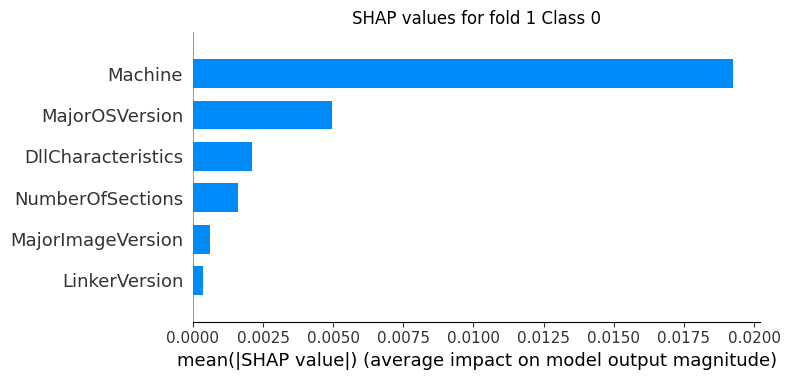

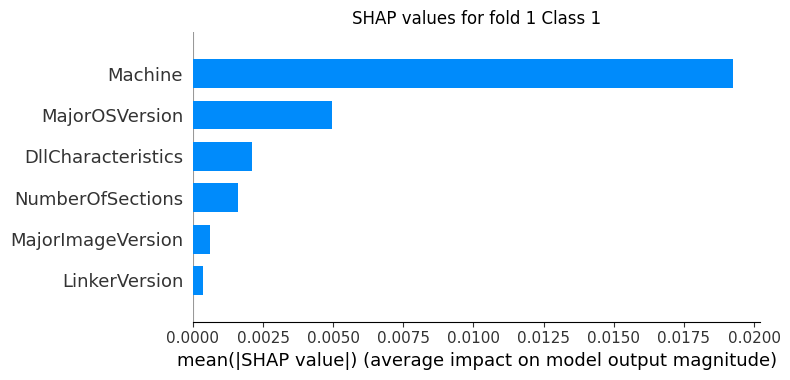

100%|===================| 12455/12498 [04:22<00:00]        

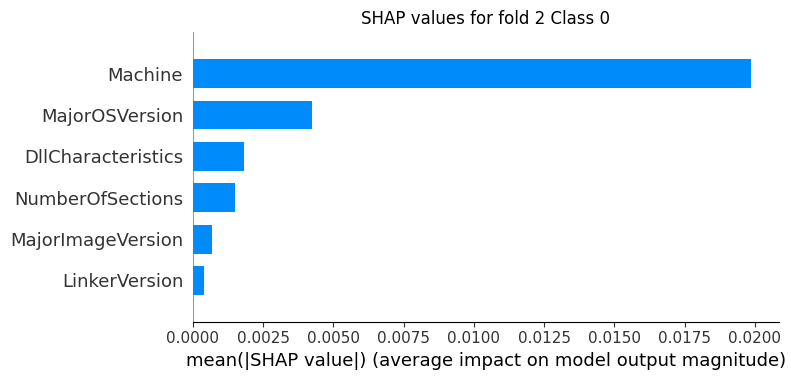

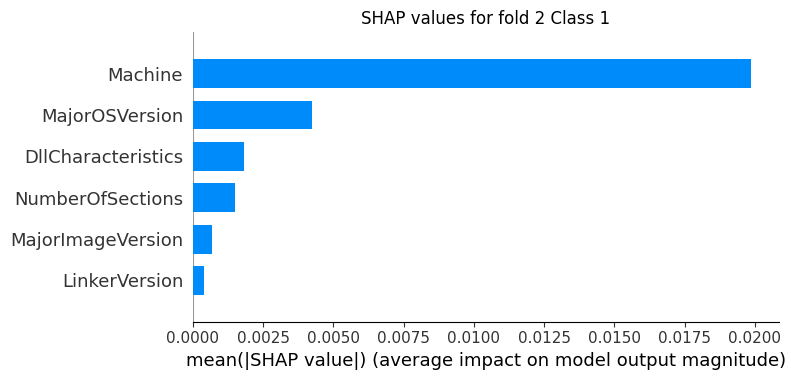

100%|===================| 12470/12498 [04:21<00:00]        

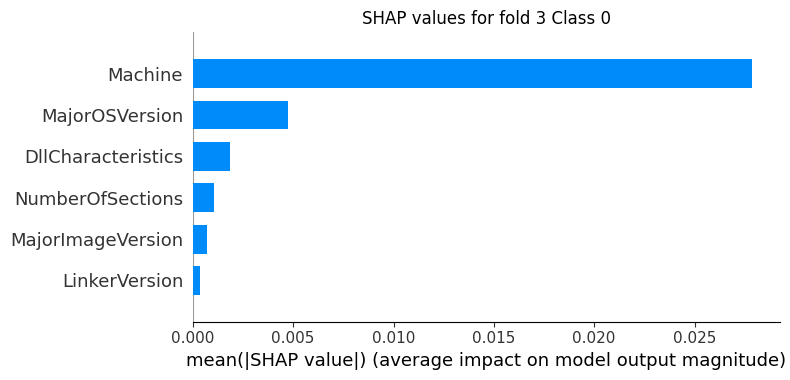

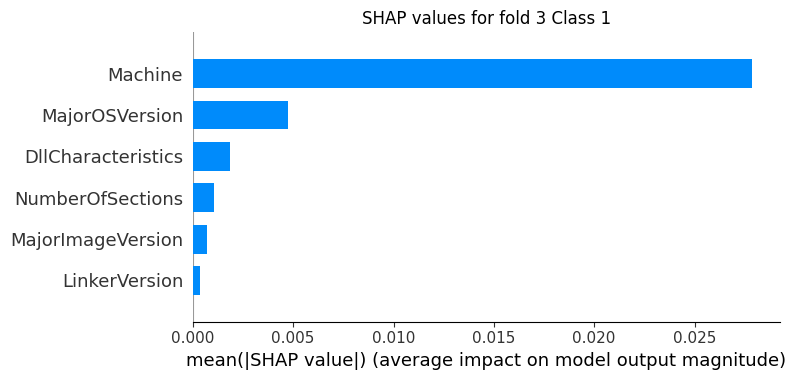

100%|===================| 12459/12498 [04:19<00:00]        

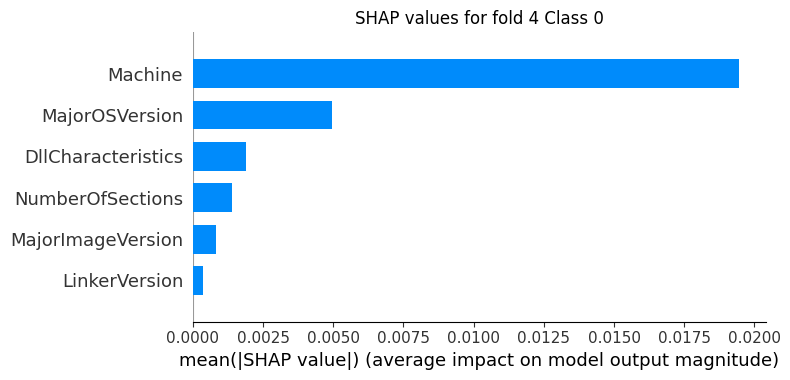

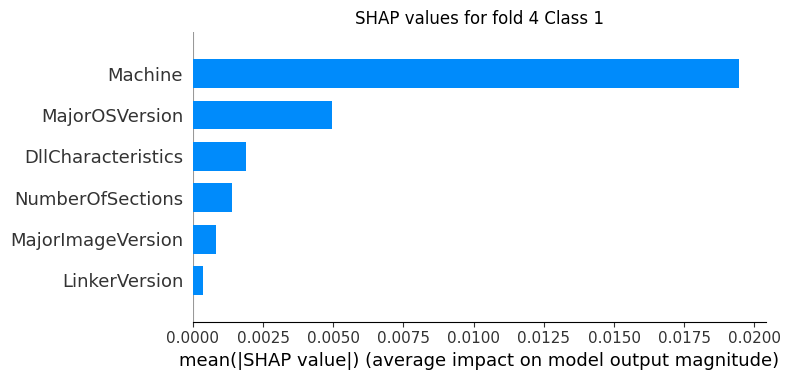

100%|===================| 12486/12498 [04:25<00:00]        

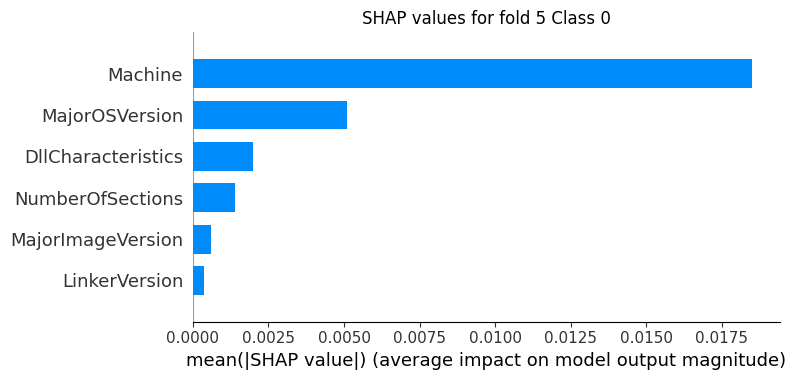

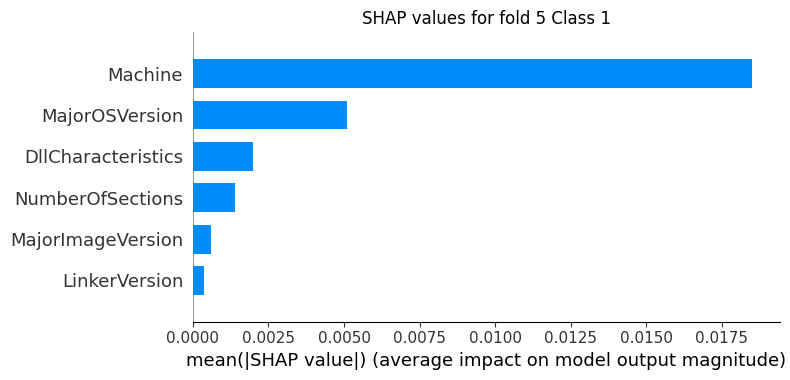

100%|===================| 12458/12496 [04:20<00:00]        

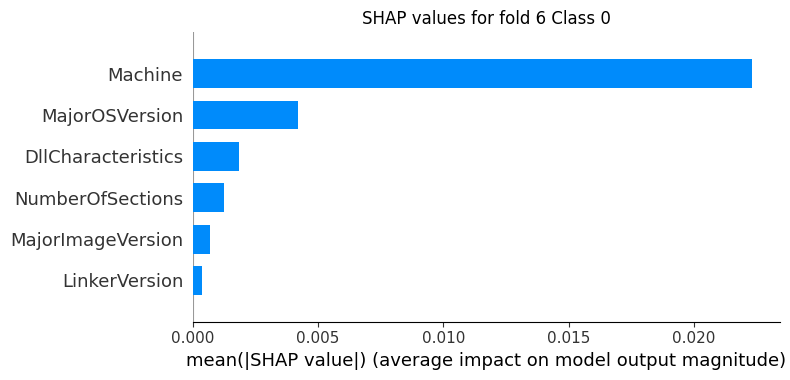

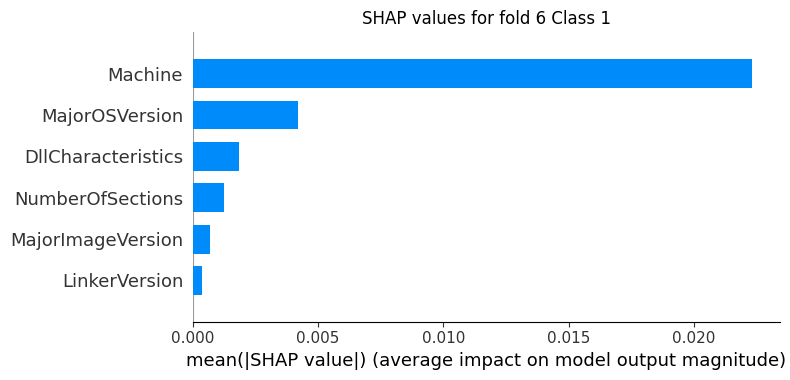

100%|===================| 12457/12496 [04:29<00:00]        

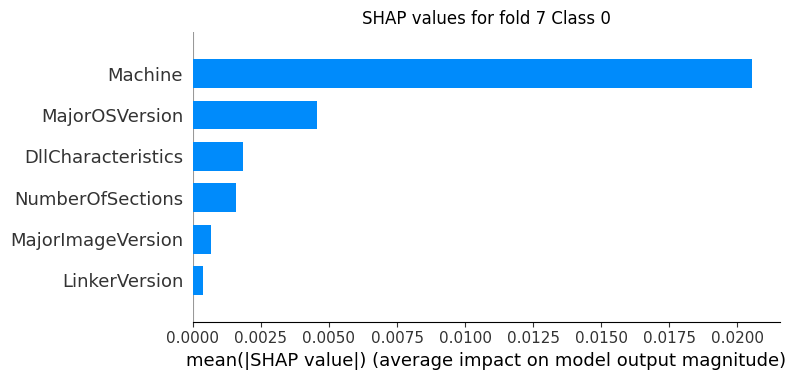

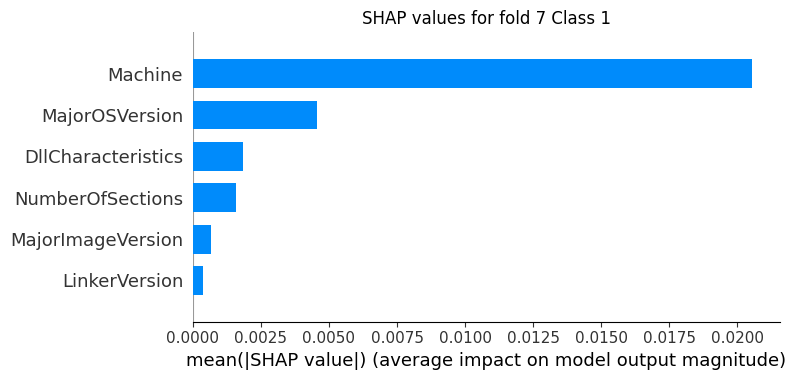

100%|===================| 12495/12496 [04:15<00:00]        

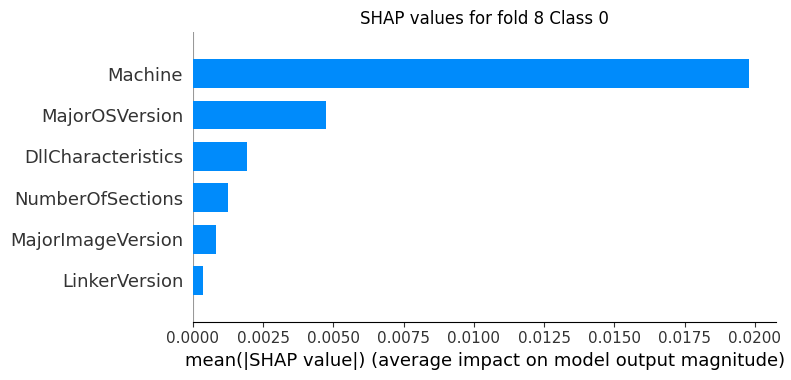

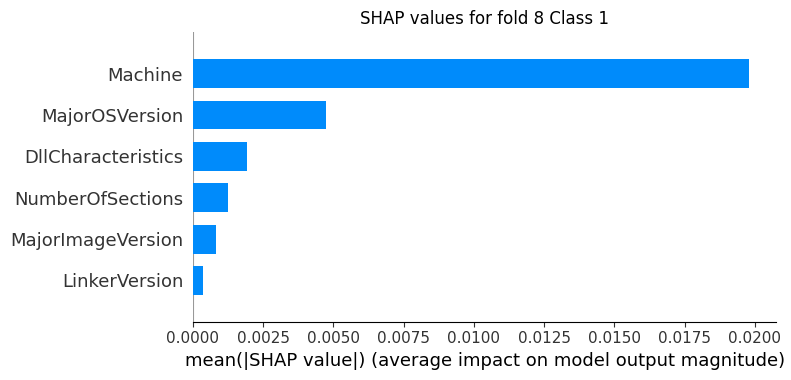

100%|===================| 12469/12496 [04:17<00:00]        

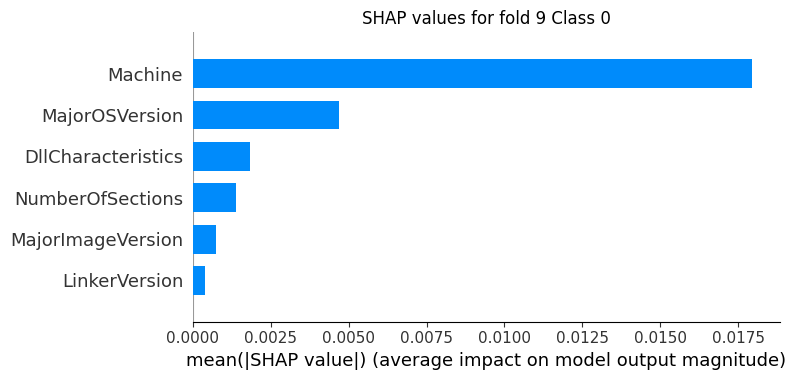

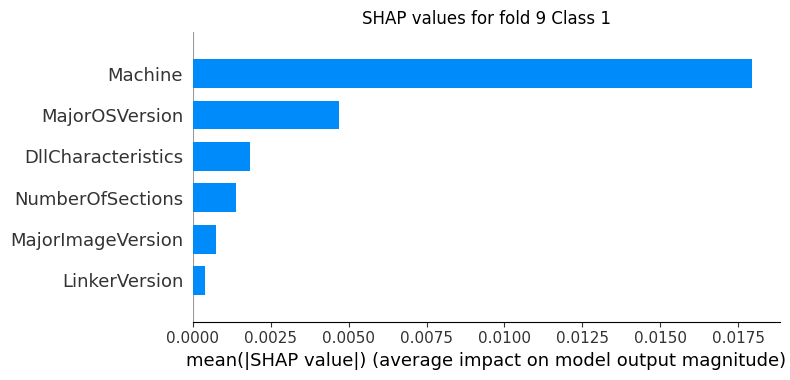

100%|===================| 12465/12496 [04:27<00:00]        

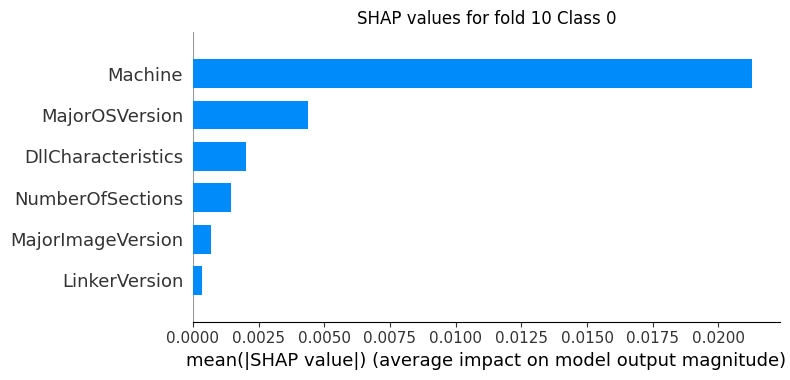

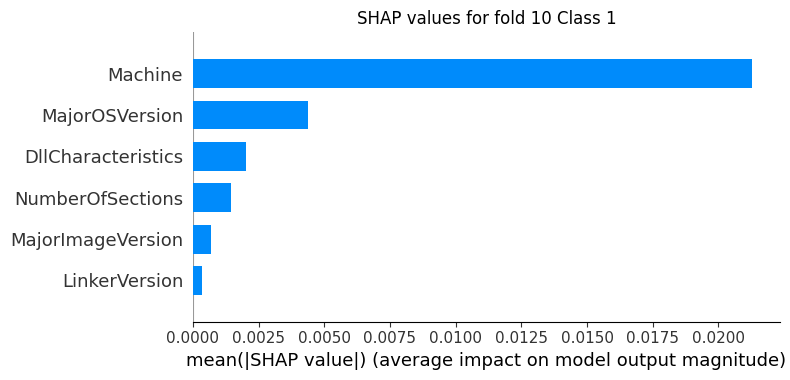

In [4]:
X = df[categorical_columns]
y = df['Benign']

preprocessor = ColumnTransformer(
    transformers=[
        ('onehot', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_jobs=1))
])

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for i, (train_idx, test_idx) in enumerate(cv.split(X, y)):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
 
    pipeline.fit(X_train, y_train)
 
    # Get feature names from one-hot encoder
    ohe = pipeline.named_steps["preprocessor"].named_transformers_["onehot"]
    ohe_feature_names = ohe.get_feature_names_out(categorical_columns)
 
    # Create SHAP explainer on the trained RandomForestClassifier
    X_test_transformed = pipeline.named_steps["preprocessor"].transform(X_test)

    # Convert sparse matrix to dense array
    X_test_dense = X_test_transformed.toarray()

    # Now create the explainer using the dense format of the transformed data
    explainer = shap.TreeExplainer(pipeline.named_steps["classifier"], X_test_dense)
    shap_values = explainer.shap_values(X_test_dense)

    # Depending on shap version, for binary classification you may have only 1 array.
    # In fact, here we have only one bidimensional array shap_values.
    shap_df_class0 = pd.DataFrame(shap_values[0], columns=ohe_feature_names)
    shap_df_class1 = pd.DataFrame(shap_values[1], columns=ohe_feature_names)
    #print(shap_df)

    # Build a map from each encoded column to its original feature
    feature_map = {}
    for encoded_col in ohe_feature_names:
        # Encoded name typically "Machine_332", etc.
        orig_feature = encoded_col.split('_')[0]
        feature_map.setdefault(orig_feature, []).append(encoded_col)
    #print(feature_map)    

    # Initialization of dictionary to contain aggregate values 
    # class 0 -> ('Malicious', value 0)
    # class 1 -> ('Benign', value 1)
    agg_shap_per_row_class0 = []        # for each object, it contains the aggregations of SHAP values of encoded feats
    agg_shap_per_row_class1 = []

    # Iterate on all rows of shap_df (all the objects in X_test)
    for index, row in shap_df_class0.iterrows():
        # Dictionaries to contain aggregate values for the current row
        row_agg_shap_class0 = {}
        
        # Somma dei valori SHAP per ogni feature originale
        # Sum of SHAP values for each original feature, splitting considering positive and negative SHAP values
        for orig_feat, enc_feats in feature_map.items():
            # Sum SHAP values of columns that belong to the same original feature considering that:
            # - Positive SHAP value means positive impact on prediction, leading the model to predict 1
            # - Negative SHAP value means negative impact, leading the model to predict 0.
            shap_values_class0 = row[enc_feats].mean()  # Media solo dei valori negativi (Classe 0)
            
            # Add aggregated results for class 0 and class 1
            if shap_values_class0 != 0:
                row_agg_shap_class0[orig_feat] = shap_values_class0
        
        # Add the aggrgated results to the correct list
        agg_shap_per_row_class0.append(row_agg_shap_class0)

    for index, row in shap_df_class1.iterrows():
        # Dictionaries to contain aggregate values for the current row
        row_agg_shap_class1 = {}
        
        # Somma dei valori SHAP per ogni feature originale
        # Sum of SHAP values for each original feature, splitting considering positive and negative SHAP values
        for orig_feat, enc_feats in feature_map.items():
            # Sum SHAP values of columns that belong to the same original feature considering that:
            # - Positive SHAP value means positive impact on prediction, leading the model to predict 1
            # - Negative SHAP value means negative impact, leading the model to predict 0.
            shap_values_class1 = row[enc_feats].mean()  # Media solo dei valori negativi (Classe 0)
            
            # Add aggregated results for class 0 and class 1
            if shap_values_class1 != 0:
                row_agg_shap_class1[orig_feat] = shap_values_class1
        
        # Add the aggrgated results to the correct list
        agg_shap_per_row_class1.append(row_agg_shap_class1)

    # Converts the list of aggregated results into a DataFrame for class 0 and class 1
    agg_shap_df_class0 = pd.DataFrame(agg_shap_per_row_class0)
    agg_shap_df_class0 = agg_shap_df_class0.fillna(0)
    agg_shap_df_class0 = agg_shap_df_class0.abs()

    agg_shap_df_class1 = pd.DataFrame(agg_shap_per_row_class1)
    agg_shap_df_class1 = agg_shap_df_class1.fillna(0)

    plt.title(f"SHAP values for fold {i + 1} Class 0")
    shap.summary_plot(agg_shap_df_class1.values, features=agg_shap_df_class1.columns, plot_type="bar")

    plt.title(f"SHAP values for fold {i + 1} Class 1")
    shap.summary_plot(agg_shap_df_class0.values, features=agg_shap_df_class0.columns, plot_type="bar")